In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import zipfile
import re
import os, fnmatch
from pprint import pprint 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
import plotly.figure_factory as ff
from shapely.geometry import Point
import shapefile
import geopandas as gpd

plt.style.use('fivethirtyeight') 
sns.set()
sns.set_context("talk")
%matplotlib inline

# Data Science for Good - How do you measure justice?

### Problem Statement 
How do you measure justice? And how do you solve the problem of racism in policing? We look for factors that drive racial disparities in policing by analyzing census and police department deployment data. The ultimate goal is to inform police agencies where they can make improvements by identifying deployment areas where racial disparities exist and are not explainable by crime rates and poverty levels.

Our biggest challenge is automating the combination of police data, census-level data, and other socioeconomic factors. Shapefiles are unusual and messy -- which makes it difficult to, for instance, generate maps of police behavior with precinct boundary layers mixed with census layers. Police incident data are also very difficult to normalize and standardize across departments since there are no federal standards for data collection..

We are trying to focus on the following general criteria:  

* Performance - How well does the solution combine shapefiles and census data? How much manual effort is needed? CPE will not be able to live-test every submission, so a strong entry will be able to automate using shape files with different projections and clearly articulate why it is effective at tackling the problem.   

* Accuracy - Does the solution provide reliable and accurate analysis? How well does it match census-level demographics to police deployment areas?   

* Approachability - The best solutions should use best coding practices and have useful comments. Plots and graphs should should be self-explanatory. CPE might use your work to explain to stakeholders where to take action,so the results of your solution should be developed for an audience of law enforcement professionals and public officials.  

In [3]:
boston = gpd.read_file("data/Dept_11-00091/11-00091_Shapefiles/boston_police_districts_f55.shp")
boston.head()

,DISTRICT_I,ID,DISTRICT,SHAPE_area,SHAPE_len,geometry
0,0.0,D14,D14,1.236310e+08,58042.148803,"POLYGON ((761381.3979588002 2953617.032912135,..."
1,0.0,A15,A15,3.798285e+07,57557.005649,"(POLYGON ((771204.100559935 2967616.400093168,..."
2,0.0,A7,A7,1.401151e+08,138468.216239,(POLYGON ((792187.2998114824 2969573.400287002...
3,0.0,A1,A1,4.545927e+07,49109.158160,"POLYGON ((777233.1995735615 2959747.999957845,..."
4,0.0,D4,D4,7.004073e+07,40964.780546,"POLYGON ((774623.0384191275 2950664.443597391,..."


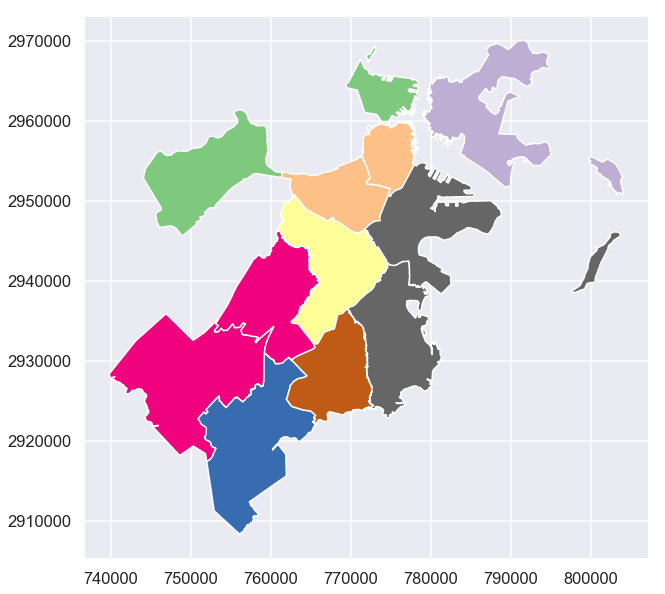

In [4]:
boston.plot(figsize = (16, 10), cmap='Accent')
plt.show()

In [14]:
field_interviews = pd.read_csv("data/Dept_11-00091/11-00091_Field-Interviews_2011-2015.csv")
field_interviews.head()

/Users/AmandaWu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (0,1,5,20,25,26,27,31,32) have mixed types. Specify dtype option on import or set low_memory=False.



,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_UNIQUE_IDENTIFIER.1,SUBJECT_GENDER,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_DISTRICT,LOCATION_DISTRICT.1,INCIDENT_DATE,INCIDENT_TIME,SUBJECT_DETAILS,SUBJECT_RACE,...,VEHICLE_DETAILS.1,OFFICER_SUPERVISOR,OFFICER_ID,OFFICER_ASSIGNMENT,OFFICER_ASSIGNMENT.1,OFFICER_ETHNICITY,OFFICER_RACE,OFFICER_AGE,LOCATION_STREET_NUMBER,LOCATION_CITY
0,SEQ_NUM,FIO_ID,SEX,LOCATION,DIST,DIST_ID,FIO_DATE,FIO_TIME,PRIORS,DESCRIPTION,...,VEH_STATE,SUPERVISOR_ID,OFFICER_ID,OFF_DIST_ID,OFF_DIST,ETHNICITY,RACE_DESC,AGE_AT_FIO_CORRECTED,STREET_ID,CITY
1,938283,621880,MALE,NORMANDY ST at SUPPLE RD,B2,3,12/10/13 0:00,12/10/13 0:00,YES,B(Black),...,MA,10132,98656,9999,OTHER,NaN,B(Black),59,3274,NO DATA ENTERED
2,881897,565177,MALE,75 BOYLSTON ST,A1,1,5/24/12 0:00,5/24/12 0:00,NO,W(White),...,NO DATA ENTERED,8949,9765,1,A1,NaN,W(White),26,543,OTHER
3,882060,565340,MALE,5 TOPLIFF ST,C11,5,6/4/12 0:00,6/4/12 0:00,YES,B(Black),...,NO DATA ENTERED,11312,83575,16,YVSF,NaN,B(Black),18,4493,NO DATA ENTERED
4,971623,653895,MALE,170 MORTON ST,B2,3,6/21/14 0:00,6/21/14 0:00,YES,B(Black),...,NO DATA ENTERED,9375,76146,25,BIKE,NaN,B(Black),24,3094,Dorchester


In [20]:
field_interviews = field_interviews[1:]
field_interviews["OFFICER_AGE"] = list(map(int, field_interviews["OFFICER_AGE"]))
officer_age = field_interviews.groupby("LOCATION_DISTRICT").mean().reset_index()
merged = officer_age.merge(boston, left_on = "LOCATION_DISTRICT", right_on = "DISTRICT")
new_merged = gpd.GeoDataFrame(merged, geometry = merged["geometry"])

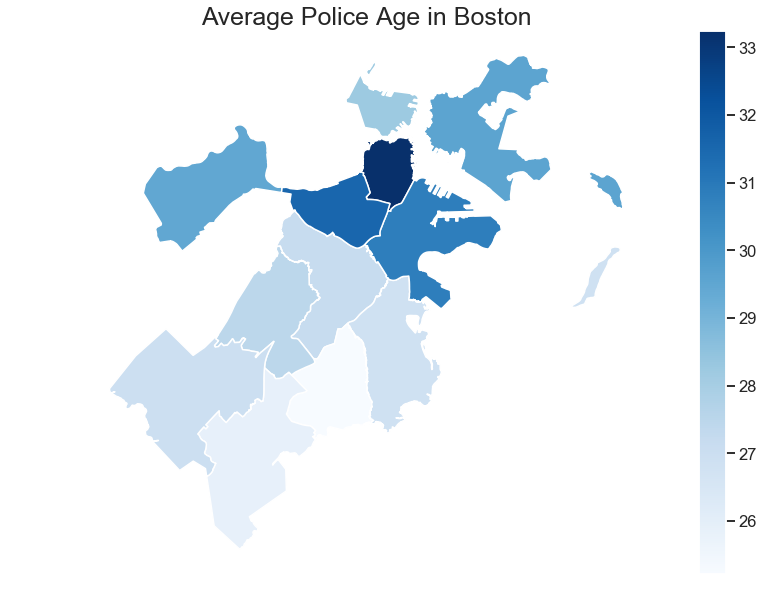

In [49]:
vmin, vmax = 0, 100
fig, ax = plt.subplots(1, figsize=(16, 10))
new_merged.plot(cmap='Blues', legend=True, ax=ax, column = "OFFICER_AGE")
ax.axis("off")

ax.set_title("Average Police Age in Boston", fontdict={"fontsize": "25", "fontweight" : "3"})
plt.show()

In [13]:
#ACS datasets

edu_attainment = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_education-attainment/ACS_16_5YR_S1501_with_ann.csv")
edu_attainment25 = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_education-attainment-over-25/ACS_16_5YR_B15003_with_ann.csv")
employment = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_employment/ACS_15_5YR_S2301_with_ann.csv")
income = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_income/ACS_15_5YR_S1903_with_ann.csv")
occupied_housing = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_owner-occupied-housing/ACS_16_5YR_S2502_with_ann.csv")
poverty = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_poverty/ACS_16_5YR_S1701_with_ann.csv")
race_sex_age = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_race-sex-age/ACS_15_5YR_DP05_with_ann.csv")

all_files = [edu_attainment,edu_attainment25,employment,income,occupied_housing,poverty,race_sex_age]
file_names = ["edu_attainment","edu_attainment25","employment","income","occupied_housing","poverty","race_sex_age"]
 


In [14]:
for i in np.arange(len(all_files)):
        print(file_names[i],": ", all_files[i].shape)

edu_attainment :  (173, 771)
edu_attainment25 :  (173, 53)
employment :  (205, 283)
income :  (205, 123)
occupied_housing :  (173, 165)
poverty :  (173, 369)
race_sex_age :  (205, 339)


In [15]:
race_sex_age.head()

,GEO.id,GEO.id2,GEO.display-label,HC01_VC03,HC02_VC03,HC03_VC03,HC04_VC03,HC01_VC04,HC02_VC04,HC03_VC04,...,HC03_VC108,HC04_VC108,HC01_VC109,HC02_VC109,HC03_VC109,HC04_VC109,HC01_VC110,HC02_VC110,HC03_VC110,HC04_VC110
0,Id,Id2,Geography,Estimate; SEX AND AGE - Total population,Margin of Error; SEX AND AGE - Total population,Percent; SEX AND AGE - Total population,Percent Margin of Error; SEX AND AGE - Total p...,Estimate; SEX AND AGE - Total population - Male,Margin of Error; SEX AND AGE - Total populatio...,Percent; SEX AND AGE - Total population - Male,...,"Percent; CITIZEN, VOTING AGE POPULATION - Citi...","Percent Margin of Error; CITIZEN, VOTING AGE P...","Estimate; CITIZEN, VOTING AGE POPULATION - Cit...","Margin of Error; CITIZEN, VOTING AGE POPULATIO...","Percent; CITIZEN, VOTING AGE POPULATION - Citi...","Percent Margin of Error; CITIZEN, VOTING AGE P...","Estimate; CITIZEN, VOTING AGE POPULATION - Cit...","Margin of Error; CITIZEN, VOTING AGE POPULATIO...","Percent; CITIZEN, VOTING AGE POPULATION - Citi...","Percent Margin of Error; CITIZEN, VOTING AGE P..."
1,1400000US25025000100,25025000100,"Census Tract 1, Suffolk County, Massachusetts",3671,364,3671,(X),1827,289,49.8,...,2704,(X),1327,292,49.1,6.6,1377,182,50.9,6.6
2,1400000US25025000201,25025000201,"Census Tract 2.01, Suffolk County, Massachusetts",3284,325,3284,(X),1494,218,45.5,...,2727,(X),1250,209,45.8,5.5,1477,208,54.2,5.5
3,1400000US25025000202,25025000202,"Census Tract 2.02, Suffolk County, Massachusetts",3587,493,3587,(X),1737,293,48.4,...,2886,(X),1435,253,49.7,5.4,1451,191,50.3,5.4
4,1400000US25025000301,25025000301,"Census Tract 3.01, Suffolk County, Massachusetts",2712,367,2712,(X),1411,339,52.0,...,2101,(X),1000,269,47.6,8.4,1101,168,52.4,8.4


In [23]:
rca_df = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_race-sex-age/ACS_15_5YR_DP05_with_ann.csv")
a_df = pd.read_csv("data/Dept_11-00091/11-00091_ACS_data/11-00091_ACS_race-sex-age/ACS_15_5YR_DP05_metadata.csv")


In [26]:
total_population = rca_df["HC01_VC03"][1:]

trace = go.Histogram(x=total_population, marker=dict(color='orange', opacity=0.6))
layout = dict(title="Total Population Distribution - Across the counties", margin=dict(l=200), width=800, height=400)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

male_pop = rca_df["HC01_VC04"][1:]
female_pop = rca_df["HC01_VC05"][1:]

trace1 = go.Histogram(x=male_pop, name="male population", marker=dict(color='blue', opacity=0.6))
trace2 = go.Histogram(x=female_pop, name="female population", marker=dict(color='pink', opacity=0.6))
layout = dict(title="Population Distribution Breakdown - Across the Census Tracts", margin=dict(l=200), width=800, height=400)
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [27]:
age_cols = []
names = []
for i in range(13):
    if i < 2:
        i = "0"+str(i+8)
        relcol = "HC01_VC" + str(i)
    else:
        relcol = "HC01_VC" + str(i+8)
    age_cols.append(relcol)
    name = a_df[a_df["GEO.id"] == relcol]["Id"].iloc(0)[0].replace("Estimate; SEX AND AGE - ","")
    names.append(name)

rca_df['GEO.display-label_cln'] = rca_df["GEO.display-label"].apply(lambda x : x.replace(", Marion County, Indiana", "").replace("Census Tract ", "CT: "))

traces = []
for i,agecol in enumerate(age_cols):
    x = rca_df["GEO.display-label_cln"][1:]
    y = rca_df[agecol][1:]
    trace = go.Bar(y=y, x=x, name=names[i])
    traces.append(trace)

tmp = pd.DataFrame()
vals = []
Geo = []
Col = []
for i,age_col in enumerate(age_cols):
    Geo += list(rca_df["GEO.display-label_cln"][1:].values)
    Col += list([names[i]]*len(rca_df[1:]))
    vals += list(rca_df[age_col][1:].values)

tmp['Geo'] = Geo
tmp['Col'] = Col
tmp['Val'] = vals
tmp['Val'] = tmp['Val'].astype(int)  * 0.01

data = [go.Scatter(x = tmp["Geo"], y = tmp["Col"], mode="markers", marker=dict(size=list(tmp["Val"].values)))]
layout = dict(title="Age Distribution by Census Tract - Marion County, Indiana", legend=dict(x=-0.1, y=1, orientation="h"), 
              margin=dict(l=150, b=100), height=600, barmode="stack")
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [29]:
trace1 = go.Histogram(x = rca_df["HC01_VC26"][1:], name="18+", marker=dict(opacity=0.4)) 
trace2 = go.Histogram(x = rca_df["HC01_VC27"][1:], name="21+", marker=dict(opacity=0.3)) 
trace3 = go.Histogram(x = rca_df["HC01_VC28"][1:], name="62+", marker=dict(opacity=0.4)) 
trace4 = go.Histogram(x = rca_df["HC01_VC29"][1:], name="65+", marker=dict(opacity=0.3)) 

titles = ["Age : 18+","Age : 21+","Age : 62+","Age : 65+",]
fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=titles)
fig.append_trace(trace1, 1, 1);
fig.append_trace(trace2, 1, 2);
fig.append_trace(trace3, 2, 1);
fig.append_trace(trace4, 2, 2);
fig['layout'].update(height=600, title="Distribution of Age across the Census Tracts", showlegend=False);
py.iplot(fig, filename='simple-subplot');

In [30]:
single_race_df = rca_df[["HC01_VC49", "HC01_VC50", "HC01_VC51", "HC01_VC56", "HC01_VC64", "HC01_VC69"]][1:]
ops = [1, 0.85, 0.75, 0.65, 0.55, 0.45]
traces = []
for i, col in enumerate(single_race_df.columns):
    nm = a_df[a_df["GEO.id"] == col]["Id"].iloc(0)[0].replace("Estimate; RACE - One race - ", "")
    trace = go.Bar(x=rca_df["GEO.display-label_cln"][1:], y=single_race_df[col], name=nm, marker=dict(opacity=0.6))
    traces.append(trace)
layout = dict(barmode="stack", title="Population Breakdown by Race (Single)", margin=dict(b=100), height=600, legend=dict(x=-0.1, y=1, orientation="h"))
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

In [31]:
traces = []
for i, col in enumerate(single_race_df.columns):
    nm = a_df[a_df["GEO.id"] == col]["Id"].iloc(0)[0].replace("Estimate; RACE - One race - ", "")
    if nm in ["White", "Black or African American"]:
        continue
    trace = go.Bar(x=rca_df["GEO.display-label_cln"][1:], y=single_race_df[col], name=nm, marker=dict(opacity=0.6))
    traces.append(trace)
layout = dict(barmode="stack", title="Population Breakdown by Race (Single)", margin=dict(b=100), height=400, legend=dict(x=-0.1, y=1, orientation="h"))
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)